In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem 1
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

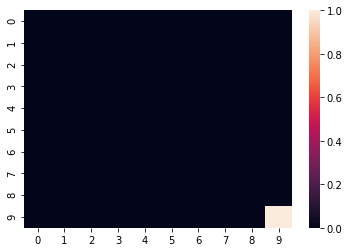

In [3]:
hm1 = sns.heatmap(Rfunc1)

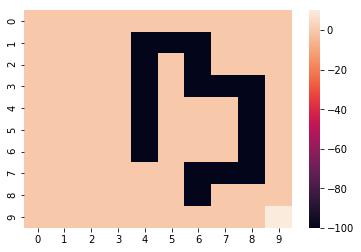

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem 2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs_new(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break
    return Vs
# def calVs_new(Vs, tp, Rfunc, discount, theta):
#     while True:
#         delta = 0.0
#         Vs_new = Vs.copy()
#         for s in range(width * height):
#             actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
#             maxActionValue = max(actionValue)
#             delta = max(np.abs(maxActionValue - Vs[s]), delta)
#             Vs_new[s] = maxActionValue
#             #print(delta)
#         if delta < theta:
#             Vs = Vs_new.copy()
#             return Vs
#             print(Vs)
        
#         Vs = Vs_new.copy()

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
# calVs(Vs1, tp, Rfunc1, discount, theta) #calculate state value for each state
Vs1 = calVs_new(Vs1, tp, Rfunc1, discount, theta)

In [11]:
from tabulate import tabulate

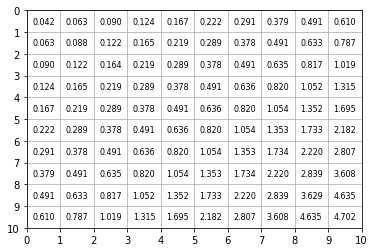

In [12]:
Vs1_2d = Vs1.reshape((height, width))
#print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))
fig = plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
for j in range(width):
    for i in range(height):
        plt.text(i + 0.5, j + 0.5, '%.3f' %Vs1_2d[i][j], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8, color='black')
plt.grid()
plt.show()

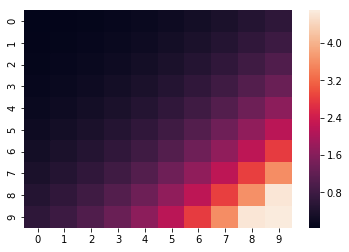

In [13]:
#problem 3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem 5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    ll = [1, 0, 3, 2]
    return [ll[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

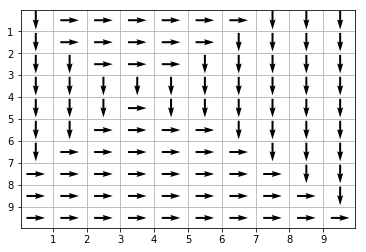

In [16]:
#optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
X = np.arange(0.5, height, 1)
Y = np.arange(0.5, width, 1)
U = np.cos(path1 * np.pi / 2)
V = np.sin(path1 * np.pi / 2)
plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
plt.quiver(X,Y,U,V,units='x',pivot='mid')
plt.grid()
plt.show()

In [17]:
#problem 6
Vs2 = np.zeros(height * width)
# calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state
Vs2 = calVs_new(Vs2, tp, Rfunc2, discount, theta)

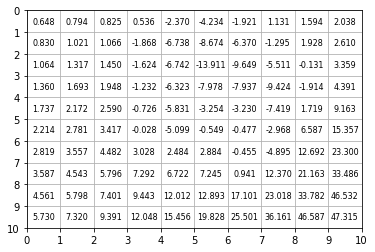

In [18]:
Vs2_2d = Vs2.reshape((height, width))
fig = plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
for j in range(width):
    for i in range(height):
        plt.text(i + 0.5, j + 0.5, '%.3f' %Vs2_2d[i][j], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8, color='black')
plt.grid()
plt.show()

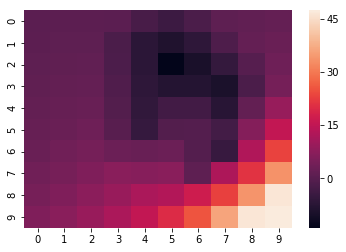

In [19]:
#problem 7
hm4 = sns.heatmap(Vs2_2d.T)

In [20]:
#problem 9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

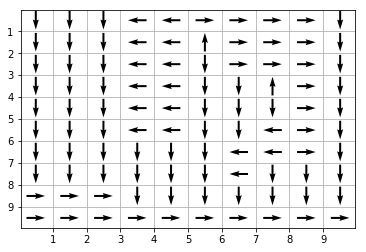

In [21]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
X = np.arange(0.5, height, 1)
Y = np.arange(0.5, width, 1)
U = np.cos(path2 * np.pi / 2)
V = np.sin(path2 * np.pi / 2)
plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
plt.quiver(X,Y,U,V,units='x',pivot='mid')
plt.grid()
plt.show()

# IRL #

In [22]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [23]:
def print_path(path):
    X = np.arange(0.5, height, 1)
    Y = np.arange(0.5, width, 1)
    U = np.cos(path * np.pi / 2)
    V = np.sin(path * np.pi / 2)
    plt.figure()
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, width + 1, 1))
    ax.set_yticks(np.arange(0, height + 1, 1))
    plt.quiver(X,Y,U,V,units='x',pivot='mid')
    plt.grid()
    plt.show()

In [24]:
def calculate_LP_D(a, s, policy, gamma, tp):
    # (Pa1 −Pa)(I−γPa1)−1
#     print(tp.shape)
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [25]:
def calculate_accuracy(n_states, ground_truth, extracted_reward):
    Vs = np.zeros(100)
    discount = 0.8
    theta = 0.01
    er = np.zeros([10,10])
    for s in range(100):
        y = int(s // height)
        x = int(s % height)
        er[x,y] = extracted_reward[s]
#     calVs(Vs, tp, er, discount, theta)
    Vs = calVs_new(Vs, tp, er, discount, theta)
    optimalAction = np.zeros(height * width)
    calOptimalAction(optimalAction, tp, er, Vs, discount)
    count = 0
    for i in range(n_states):
        if ground_truth[i] == optimalAction[i]:
            count += 1
    return float(count)/float(n_states)

In [26]:
#Question 11:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
lamda_list = np.linspace(0,5,500)
A = {0,1,2,3}
n_actions = 4
n_states = 100
gamma = 0.8
tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
transition_probability = np.transpose(tpm, (1, 0, 2))
Rmax1 = 0.0
for i in range(0,10):
    for j in range(0,10):
        Rmax1 = max(Rmax1, abs(Rfunc1[i,j]))   
Rmax2 = 0.0
for i in range(0,10):
    for j in range(0,10):
        Rmax2 = max(Rmax2, abs(Rfunc2[i,j]))  

In [27]:
def normalize(vals):
    min_val = np.min(vals)
    max_val = np.max(vals)
    return (vals - min_val) / (max_val - min_val)

In [28]:
def perform_IRL_4Attrs(optimalAction, transition_probability, Rmax, lamda_list):
    accuracy = []
    for lamda in lamda_list:
        n_states = 100
        policy = optimalAction
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100), np.zeros(100)]) 
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, M]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100)),np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])
        d = matrix(D)
        B = np.zeros((1000,1))
        b = matrix(B)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        res = r.reshape((n_states,))
#         print(res)
        temp_acc = calculate_accuracy(100, optimalAction, res)
        print(temp_acc)
        accuracy.append(temp_acc)
    return {'accuracy':accuracy, 'reward': res}

In [29]:
def perform_IRL_3Attrs(policy, transition_probability, Rmax, lamda_list):
    accuracy = []
    for lamda in lamda_list:
        n_states = 100
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100)]) 
#         print(C)
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, RMax]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])        
        d = matrix(D)
        b = np.zeros((800, 1))
        b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
        b = np.vstack((b, b_bounds))
        b = matrix(b)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        res = r.reshape((n_states,))
#         print(res)
        temp_acc = calculate_accuracy(100, policy, res)
        print(temp_acc)
        accuracy.append(temp_acc)
    return {'accuracy':accuracy, 'reward': res}

In [30]:
# res1_2 = perform_IRL_3Attrs(optimalAction1, transition_probability,Rmax1 , lamda_list)
# accuracy1_2 = res1_2['accuracy']
# plt.plot(lamda_list, accuracy1_2)
# plt.show()

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5706e+00 -0.0000e+00  7e+02  1e+01  7e+00  3e+00
 2: -7.5495e+00 -0.0000e+00  2e+03  1e+01  6e+00  8e+00
 3: -6.6356e+01 -0.0000e+00  2e+04  1e+01  7e+00  7e+01
 4: -1.2930e+03 -0.0000e+00  5e+05  1e+01  7e+00  1e+03
 5: -1.2779e+05 -0.0000e+00  5e+07  1e+01  7e+00  1e+05
 6: -1.2779e+07 -0.0000e+00  5e+09  1e+01  7e+00  1e+07
 7: -1.2779e+09 -0.0000e+00  5e+11  1e+01  7e+00  1e+09
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.6041e+00 -0.0000e+00  7e+02  1e+01  7e+00  3e+00
 2: -7.1735e+00 -0.0000e+00  2e+03  1e+01  6e+00  8e+00
 3: -6.1204e+01 -0.0000e+00  2e+04  1e+01  7e+00  6e+01
 4: -1.1753e+03 -0.0000e+00  4e+05  1e+01  7e+00  1e+03
 5: -1.1589e+05 -0.0000e+00  4e+07  1e+01  7e+00  1e+05
 6: -1.1589e+07 -0.0000e+00  4e+09  1e+01  7e+00  1e+07
 7: -1.

0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9473e+00 -0.0000e+00  5e+02  1e+01  6e+00  3e+00
 2: -4.1149e+00 -0.0000e+00  5e+02  8e+00  4e+00  4e+00
 3: -2.0782e+01 -0.0000e+00  3e+03  7e+00  3e+00  2e+01
 4: -4.1967e+02 -0.0000e+00  6e+04  7e+00  3e+00  4e+02
 5: -3.9700e+04 -0.0000e+00  6e+06  7e+00  3e+00  4e+04
 6: -3.9700e+06 -0.0000e+00  6e+08  7e+00  3e+00  4e+06
 7: -3.9700e+08 -0.0000e+00  6e+10  7e+00  3e+00  4e+08
Certificate of dual infeasibility found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9628e+00 -0.0000e+00  5e+02  1e+01  6e+00  3e+00
 2: -4.0069e+00 -0.0000e+00  5e+02  8e+00  4e+00  4e+00
 3: -1.9312e+01 -0.0000e+00  3e+03  6e+00  3e+00  2e+01
 4: -3.8779e+02 -0.0000e+00  5e+04  7e+00  3e+00  4e+02
 5: -3.6673e+04 -0.0000e+00  5e+06  7e+00  3e+00  4e+04
 6: -3.6672e+06 -0.0000e+00  5e+08  7e+00  3e+00  4e+06
 

0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -3.1270e+00 -0.0000e+00  4e+02  1e+01  5e+00  3e+00
 2: -3.1205e+00 -0.0000e+00  3e+02  6e+00  3e+00  3e+00
 3: -6.2093e+00 -0.0000e+00  4e+02  4e+00  2e+00  6e+00
 4: -9.3348e+01 -0.0000e+00  7e+03  4e+00  2e+00  9e+01
 5: -5.4610e+03 -0.0000e+00  4e+05  4e+00  2e+00  5e+03
 6: -5.4602e+05 -0.0000e+00  4e+07  4e+00  2e+00  5e+05
 7: -5.4602e+07 -0.0000e+00  4e+09  4e+00  2e+00  5e+07
Certificate of dual infeasibility found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -3.1348e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -3.0809e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -5.7743e+00 -0.0000e+00  4e+02  4e+00  2e+00  6e+00
 4: -7.9253e+01 -0.0000e+00  6e+03  4e+00  2e+00  8e+01
 5: -4.0675e+03 -0.0000e+00  3e+05  4e+00  2e+00  4e+03
 6: -4.0666e+05 -0.0000e+00  3e+07  4e+00  2e+00  4e+05
 

0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -3.1105e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -2.5796e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -2.5614e+00 -0.0000e+00  1e+02  3e+00  1e+00  3e+00
 4: -1.5419e+01 -0.0000e+00  9e+02  2e+00  1e+00  2e+01
 5: -2.3732e+02 -0.0000e+00  1e+04  2e+00  1e+00  2e+02
 6: -2.3377e+04 -0.0000e+00  1e+06  2e+00  1e+00  2e+04
 7: -2.3376e+06 -0.0000e+00  1e+08  2e+00  1e+00  2e+06
 8: -2.3376e+08 -0.0000e+00  1e+10  2e+00  1e+00  2e+08
Certificate of dual infeasibility found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -3.1011e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -2.5429e+00 -0.0000e+00  2e+02  5e+00  2e+00  3e+00
 3: -2.4213e+00 -0.0000e+00  1e+02  3e+00  1e+00  3e+00
 4: -1.3686e+01 -0.0000e+00  8e+02  2e+00  1e+00  1e+01
 5: -2.0034e+02 -0.0000e+00  1e+04  2e+00  1e+00  2e+02
 

0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.9352e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -2.1089e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.1979e+00 -0.0000e+00  6e+01  2e+00  9e-01  1e+00
 4: -2.7742e+00 -0.0000e+00  1e+02  1e+00  6e-01  3e+00
 5: -3.2431e+01 -0.0000e+00  2e+03  1e+00  6e-01  3e+01
 6: -2.9572e+03 -0.0000e+00  2e+05  1e+00  6e-01  3e+03
 7: -2.9570e+05 -0.0000e+00  2e+07  1e+00  6e-01  3e+05
 8: -2.9570e+07 -0.0000e+00  2e+09  1e+00  6e-01  3e+07
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.9197e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -2.0779e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.1348e+00 -0.0000e+00  6e+01  2e+00  8e-01  1e+00
 4: -2.4366e+00 -0.0000e+00  1e+02  1e+00  5e-01  2e+00
 5: -2.8432e+01 -0.0000e+00  2e+03  1e+00  6e-01  3e+01
 6:

0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.6688e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.7019e+00 -0.0000e+00  9e+01  4e+00  2e+00  2e+00
 3: -5.3504e-01 -0.0000e+00  3e+01  1e+00  6e-01  6e-01
 4: -3.7731e-01 -0.0000e+00  2e+01  6e-01  3e-01  4e-01
 5: -3.1329e+00 -0.0000e+00  3e+02  9e-01  4e-01  3e+00
 6: -1.2972e+02 -0.0000e+00  1e+04  8e-01  3e-01  1e+02
 7: -1.2953e+04 -0.0000e+00  1e+06  8e-01  3e-01  1e+04
 8: -1.2952e+06 -0.0000e+00  1e+08  8e-01  3e-01  1e+06
 9: -1.2952e+08 -0.0000e+00  1e+10  8e-01  3e-01  1e+08
Certificate of dual infeasibility found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.6444e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.6738e+00 -0.0000e+00  8e+01  4e+00  2e+00  2e+00
 3: -5.1366e-01 -0.0000e+00  3e+01  1e+00  6e-01  6e-01
 4: -3.2737e-01 -0.0000e+00  2e+01  6e-01  2e-01  3e-01
 5:

0.67
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.3896e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.3793e+00 -0.0000e+00  7e+01  3e+00  1e+00  1e+00
 3: -3.7903e-01 -0.0000e+00  2e+01  1e+00  5e-01  4e-01
 4: -1.1420e-01 -0.0000e+00  8e+00  5e-01  2e-01  1e-01
 5: -2.9792e-02 -0.0000e+00  2e+00  2e-01  6e-02  3e-02
 6: -1.2960e-02 -0.0000e+00  2e+00  1e-01  5e-02  2e-02
 7: -4.1424e-03 -0.0000e+00  6e-01  5e-02  2e-02  6e-03
 8: -8.9442e-04 -0.0000e+00  2e-01  2e-02  7e-03  2e-03
 9: -1.1404e-04 -0.0000e+00  7e-02  7e-03  3e-03  3e-04
10:  1.5778e-05 -0.0000e+00  7e-03  8e-04  3e-04  9e-06
11:  5.7172e-07 -0.0000e+00  2e-04  3e-05  1e-05  3e-07
12:  5.7279e-09 -0.0000e+00  2e-06  3e-07  1e-07  3e-09
13:  5.7279e-11 -0.0000e+00  2e-08  3e-09  1e-09  3e-11
Optimal solution found.
0.72
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.3677e+00 -0

 3: -2.4174e-01 -0.0000e+00  2e+01  1e+00  4e-01  3e-01
 4: -4.1819e-02 -0.0000e+00  4e+00  3e-01  1e-01  5e-02
 5: -4.7795e-03 -0.0000e+00  5e-01  5e-02  2e-02  6e-03
 6:  5.2425e-05 -0.0000e+00  4e-02  4e-03  1e-03  8e-05
 7:  5.3572e-07 -0.0000e+00  4e-04  4e-05  2e-05  8e-07
 8:  5.3569e-09 -0.0000e+00  4e-06  4e-07  2e-07  8e-09
 9:  5.3569e-11 -0.0000e+00  4e-08  4e-09  2e-09  8e-11
Optimal solution found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.1408e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.1391e+00 -0.0000e+00  5e+01  3e+00  1e+00  1e+00
 3: -2.3067e-01 -0.0000e+00  2e+01  1e+00  4e-01  3e-01
 4: -3.6763e-02 -0.0000e+00  3e+00  3e-01  1e-01  5e-02
 5: -5.2494e-03 -0.0000e+00  5e-01  5e-02  2e-02  7e-03
 6:  3.6051e-05 -0.0000e+00  3e-02  3e-03  1e-03  7e-05
 7:  3.6424e-07 -0.0000e+00  3e-04  3e-05  1e-05  7e-07
 8:  3.6422e-09 -0.0000e+00  3e-06  3e-07  1e-07  7e-09
 9:  3.6422e-11 -0.00

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.9053e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -1.0113e+00 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.3824e-01 -0.0000e+00  1e+01  7e-01  3e-01  2e-01
 4: -1.6397e-02 -0.0000e+00  2e+00  1e-01  5e-02  2e-02
 5:  6.9667e-05 -0.0000e+00  1e-01  1e-02  4e-03  3e-04
 6:  7.1388e-07 -0.0000e+00  1e-03  1e-04  4e-05  3e-06
 7:  7.1382e-09 -0.0000e+00  1e-05  1e-06  4e-07  3e-08
 8:  7.1382e-11 -0.0000e+00  1e-07  1e-08  4e-09  3e-10
 9:  7.1382e-13 -0.0000e+00  1e-09  1e-10  4e-11  3e-12
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.8885e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -1.0007e+00 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.3607e-01 -0.0000e+00  1e+01  7e-01  2e-01  2e-01
 4: -1.7702e-02 -0.0000e+00  2e+00  1e-01  5e-02  2e-02
 5:  5.9675e-05 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6678e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -8.7672e-01 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.2703e-01 -0.0000e+00  9e+00  6e-01  2e-01  1e-01
 4: -1.8590e-02 -0.0000e+00  1e+00  1e-01  4e-02  2e-02
 5: -1.3201e-04 -0.0000e+00  3e-02  3e-03  8e-04  2e-04
 6: -1.3191e-06 -0.0000e+00  3e-04  3e-05  8e-06  2e-06
 7: -1.3191e-08 -0.0000e+00  3e-06  3e-07  8e-08  2e-08
 8: -1.3191e-10 -0.0000e+00  3e-08  3e-09  8e-10  2e-10
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6519e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -8.6698e-01 -0.0000e+00  6e+01  3e+00  1e+00  1e+00
 3: -1.4248e-01 -0.0000e+00  9e+00  7e-01  2e-01  2e-01
 4: -2.4117e-02 -0.0000e+00  2e+00  1e-01  4e-02  3e-02
 5: -1.4624e-04 -0.0000e+00  4e-02  4e-03  1e-03  3e-04
 6: -1.4617e-06 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.4647e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -7.4159e-01 -0.0000e+00  6e+01  3e+00  9e-01  8e-01
 3: -1.9060e-01 -0.0000e+00  1e+01  9e-01  3e-01  2e-01
 4: -1.8276e-02 -0.0000e+00  2e+00  1e-01  4e-02  2e-02
 5: -1.4040e-04 -0.0000e+00  3e-02  2e-03  7e-04  2e-04
 6: -1.4031e-06 -0.0000e+00  3e-04  2e-05  7e-06  2e-06
 7: -1.4031e-08 -0.0000e+00  3e-06  2e-07  7e-08  2e-08
 8: -1.4031e-10 -0.0000e+00  3e-08  2e-09  7e-10  2e-10
Optimal solution found.
0.75
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.4516e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -7.3224e-01 -0.0000e+00  6e+01  3e+00  9e-01  8e-01
 3: -1.8907e-01 -0.0000e+00  1e+01  9e-01  3e-01  2e-01
 4: -1.7244e-02 -0.0000e+00  1e+00  1e-01  4e-02  2e-02
 5: -1.3635e-04 -0.0000e+00  2e-02  2e-03  6e-04  2e-04
 6: -1.3627e-06 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.2960e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.1689e-01 -0.0000e+00  5e+01  3e+00  8e-01  7e-01
 3: -1.5172e-01 -0.0000e+00  1e+01  8e-01  2e-01  2e-01
 4: -2.8560e-03 -0.0000e+00  6e-01  5e-02  1e-02  4e-03
 5: -2.8146e-05 -0.0000e+00  6e-03  5e-04  1e-04  4e-05
 6: -2.8142e-07 -0.0000e+00  6e-05  5e-06  1e-06  4e-07
 7: -2.8142e-09 -0.0000e+00  6e-07  5e-08  1e-08  4e-09
 8: -2.8142e-11 -0.0000e+00  6e-09  5e-10  1e-10  4e-11
Optimal solution found.
0.78
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.2851e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.0853e-01 -0.0000e+00  5e+01  3e+00  8e-01  7e-01
 3: -1.4823e-01 -0.0000e+00  1e+01  7e-01  2e-01  2e-01
 4: -1.7424e-03 -0.0000e+00  5e-01  4e-02  1e-02  3e-03
 5: -1.7370e-05 -0.0000e+00  6e-03  5e-04  1e-04  3e-05
 6: -1.7367e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.1547e+00 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -5.0697e-01 -0.0000e+00  5e+01  2e+00  7e-01  6e-01
 3: -9.7276e-02 -0.0000e+00  7e+00  5e-01  1e-01  1e-01
 4: -6.9342e-04 -0.0000e+00  2e-01  2e-02  5e-03  1e-03
 5: -6.9834e-06 -0.0000e+00  2e-03  2e-04  5e-05  1e-05
 6: -6.9830e-08 -0.0000e+00  2e-05  2e-06  5e-07  1e-07
 7: -6.9830e-10 -0.0000e+00  2e-07  2e-08  5e-09  1e-09
 8: -6.9830e-12 -0.0000e+00  2e-09  2e-10  5e-11  1e-11
Optimal solution found.
0.78
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.1455e+00 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.9969e-01 -0.0000e+00  5e+01  2e+00  6e-01  6e-01
 3: -9.3446e-02 -0.0000e+00  7e+00  5e-01  1e-01  1e-01
 4: -8.9597e-04 -0.0000e+00  2e-01  2e-02  5e-03  2e-03
 5: -9.0179e-06 -0.0000e+00  2e-03  2e-04  5e-05  2e-05
 6: -9.0174e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.0353e+00 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.1158e-01 -0.0000e+00  4e+01  2e+00  5e-01  5e-01
 3: -4.8397e-02 -0.0000e+00  4e+00  3e-01  8e-02  6e-02
 4: -4.1560e-04 -0.0000e+00  1e-01  1e-02  2e-03  7e-04
 5: -4.1599e-06 -0.0000e+00  1e-03  1e-04  3e-05  7e-06
 6: -4.1598e-08 -0.0000e+00  1e-05  1e-06  3e-07  7e-08
 7: -4.1598e-10 -0.0000e+00  1e-07  1e-08  3e-09  7e-10
 8: -4.1598e-12 -0.0000e+00  1e-09  1e-10  3e-11  7e-12
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -1.0275e+00 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.0528e-01 -0.0000e+00  4e+01  2e+00  5e-01  5e-01
 3: -4.5334e-02 -0.0000e+00  4e+00  3e-01  7e-02  5e-02
 4: -2.8745e-04 -0.0000e+00  1e-01  9e-03  2e-03  6e-04
 5: -2.8761e-06 -0.0000e+00  1e-03  9e-05  2e-05  6e-06
 6: -2.8760e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -9.2015e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.2243e-01 -0.0000e+00  3e+01  2e+00  4e-01  4e-01
 3: -2.6302e-02 -0.0000e+00  3e+00  2e-01  5e-02  3e-02
 4: -2.6334e-04 -0.0000e+00  4e-02  3e-03  7e-04  4e-04
 5: -2.6320e-06 -0.0000e+00  4e-04  3e-05  7e-06  4e-06
 6: -2.6320e-08 -0.0000e+00  4e-06  3e-07  7e-08  4e-08
 7: -2.6320e-10 -0.0000e+00  4e-08  3e-09  7e-10  4e-10
Optimal solution found.
0.75
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -9.1360e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.1914e-01 -0.0000e+00  3e+01  2e+00  4e-01  4e-01
 3: -2.5671e-02 -0.0000e+00  3e+00  2e-01  5e-02  3e-02
 4: -2.5823e-04 -0.0000e+00  4e-02  3e-03  7e-04  4e-04
 5: -2.5810e-06 -0.0000e+00  4e-04  3e-05  7e-06  4e-06
 6: -2.5810e-08 -0.0000e+00  4e-06  3e-07  7e-08  4e-08
 7: -2.5810e-10 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -8.2291e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -2.7451e-01 -0.0000e+00  3e+01  2e+00  4e-01  3e-01
 3: -1.6351e-02 -0.0000e+00  2e+00  2e-01  3e-02  2e-02
 4: -1.6984e-04 -0.0000e+00  3e-02  2e-03  4e-04  2e-04
 5: -1.6979e-06 -0.0000e+00  3e-04  2e-05  4e-06  2e-06
 6: -1.6979e-08 -0.0000e+00  3e-06  2e-07  4e-08  2e-08
 7: -1.6979e-10 -0.0000e+00  3e-08  2e-09  4e-10  2e-10
Optimal solution found.
0.72
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -8.1734e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -2.7182e-01 -0.0000e+00  3e+01  2e+00  4e-01  3e-01
 3: -1.5755e-02 -0.0000e+00  2e+00  2e-01  3e-02  2e-02
 4: -1.6371e-04 -0.0000e+00  3e-02  2e-03  4e-04  2e-04
 5: -1.6366e-06 -0.0000e+00  3e-04  2e-05  4e-06  2e-06
 6: -1.6366e-08 -0.0000e+00  3e-06  2e-07  4e-08  2e-08
 7: -1.6366e-10 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -7.4007e-01 -0.0000e+00  3e+02  8e+00  2e+00  1e+00
 2: -2.3523e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -7.4798e-03 -0.0000e+00  2e+00  1e-01  2e-02  1e-02
 4: -7.7096e-05 -0.0000e+00  2e-02  1e-03  2e-04  1e-04
 5: -7.7082e-07 -0.0000e+00  2e-04  1e-05  2e-06  1e-06
 6: -7.7082e-09 -0.0000e+00  2e-06  1e-07  2e-08  1e-08
 7: -7.7082e-11 -0.0000e+00  2e-08  1e-09  2e-10  1e-10
Optimal solution found.
0.71
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -7.3531e-01 -0.0000e+00  2e+02  8e+00  2e+00  1e+00
 2: -2.3301e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -7.2753e-03 -0.0000e+00  2e+00  1e-01  2e-02  1e-02
 4: -7.4956e-05 -0.0000e+00  2e-02  1e-03  2e-04  1e-04
 5: -7.4943e-07 -0.0000e+00  2e-04  1e-05  2e-06  1e-06
 6: -7.4943e-09 -0.0000e+00  2e-06  1e-07  2e-08  1e-08
 7: -7.4943e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -6.6904e-01 -0.0000e+00  2e+02  8e+00  2e+00  9e-01
 2: -2.0261e-01 -0.0000e+00  3e+01  1e+00  3e-01  2e-01
 3: -5.6958e-03 -0.0000e+00  2e+00  1e-01  2e-02  9e-03
 4: -5.9224e-05 -0.0000e+00  2e-02  1e-03  2e-04  9e-05
 5: -5.9215e-07 -0.0000e+00  2e-04  1e-05  2e-06  9e-07
 6: -5.9215e-09 -0.0000e+00  2e-06  1e-07  2e-08  9e-09
 7: -5.9215e-11 -0.0000e+00  2e-08  1e-09  2e-10  9e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -6.6494e-01 -0.0000e+00  2e+02  8e+00  2e+00  9e-01
 2: -2.0076e-01 -0.0000e+00  3e+01  1e+00  3e-01  2e-01
 3: -5.6028e-03 -0.0000e+00  2e+00  1e-01  2e-02  9e-03
 4: -5.8254e-05 -0.0000e+00  2e-02  1e-03  2e-04  9e-05
 5: -5.8245e-07 -0.0000e+00  2e-04  1e-05  2e-06  9e-07
 6: -5.8245e-09 -0.0000e+00  2e-06  1e-07  2e-08  9e-09
 7: -5.8245e-11 -0.0000e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -6.0764e-01 -0.0000e+00  2e+02  8e+00  1e+00  9e-01
 2: -1.7523e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -4.3752e-03 -0.0000e+00  2e+00  9e-02  2e-02  7e-03
 4: -4.5251e-05 -0.0000e+00  2e-02  9e-04  2e-04  7e-05
 5: -4.5245e-07 -0.0000e+00  2e-04  9e-06  2e-06  7e-07
 6: -4.5245e-09 -0.0000e+00  2e-06  9e-08  2e-08  7e-09
 7: -4.5245e-11 -0.0000e+00  2e-08  9e-10  2e-10  7e-11
Optimal solution found.
0.71
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -6.0409e-01 -0.0000e+00  2e+02  8e+00  1e+00  9e-01
 2: -1.7366e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -4.3039e-03 -0.0000e+00  2e+00  9e-02  2e-02  7e-03
 4: -4.4493e-05 -0.0000e+00  2e-02  9e-04  2e-04  7e-05
 5: -4.4487e-07 -0.0000e+00  2e-04  9e-06  2e-06  7e-07
 6: -4.4487e-09 -0.0000e+00  2e-06  9e-08  2e-08  7e-09
 7: -4.4487e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.5419e-01 -0.0000e+00  2e+02  8e+00  1e+00  8e-01
 2: -1.5196e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -3.3761e-03 -0.0000e+00  2e+00  8e-02  1e-02  6e-03
 4: -3.4788e-05 -0.0000e+00  2e-02  8e-04  1e-04  6e-05
 5: -3.4784e-07 -0.0000e+00  2e-04  8e-06  1e-06  6e-07
 6: -3.4784e-09 -0.0000e+00  2e-06  8e-08  1e-08  6e-09
 7: -3.4784e-11 -0.0000e+00  2e-08  8e-10  1e-10  6e-11
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.5108e-01 -0.0000e+00  2e+02  8e+00  1e+00  8e-01
 2: -1.5072e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -3.3229e-03 -0.0000e+00  2e+00  8e-02  1e-02  6e-03
 4: -3.4228e-05 -0.0000e+00  2e-02  8e-04  1e-04  6e-05
 5: -3.4224e-07 -0.0000e+00  2e-04  8e-06  1e-06  6e-07
 6: -3.4224e-09 -0.0000e+00  2e-06  8e-08  1e-08  6e-09
 7: -3.4224e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.0732e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.3653e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.6117e-03 -0.0000e+00  1e+00  7e-02  1e-02  5e-03
 4: -2.6596e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.6593e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.6593e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.6593e-11 -0.0000e+00  1e-08  7e-10  1e-10  5e-11
Optimal solution found.
0.76
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -5.0459e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.3565e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.5939e-03 -0.0000e+00  1e+00  7e-02  1e-02  5e-03
 4: -2.6400e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.6397e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.6397e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.6397e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.6598e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.2318e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.4951e-03 -0.0000e+00  1e+00  6e-02  1e-02  4e-03
 4: -2.5225e-05 -0.0000e+00  1e-02  6e-04  1e-04  5e-05
 5: -2.5223e-07 -0.0000e+00  1e-04  6e-06  1e-06  5e-07
 6: -2.5223e-09 -0.0000e+00  1e-06  6e-08  1e-08  5e-09
 7: -2.5223e-11 -0.0000e+00  1e-08  6e-10  1e-10  5e-11
Optimal solution found.
0.74
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.6356e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.2240e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.4851e-03 -0.0000e+00  1e+00  6e-02  1e-02  4e-03
 4: -2.5114e-05 -0.0000e+00  1e-02  6e-04  1e-04  4e-05
 5: -2.5112e-07 -0.0000e+00  1e-04  6e-06  1e-06  4e-07
 6: -2.5112e-09 -0.0000e+00  1e-06  6e-08  1e-08  4e-09
 7: -2.5112e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.2932e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.1129e-01 -0.0000e+00  3e+01  1e+00  2e-01  1e-01
 3: -2.2962e-03 -0.0000e+00  1e+00  5e-02  8e-03  4e-03
 4: -2.3092e-05 -0.0000e+00  1e-02  5e-04  8e-05  4e-05
 5: -2.3091e-07 -0.0000e+00  1e-04  5e-06  8e-07  4e-07
 6: -2.3091e-09 -0.0000e+00  1e-06  5e-08  8e-09  4e-09
 7: -2.3091e-11 -0.0000e+00  1e-08  5e-10  8e-11  4e-11
Optimal solution found.
0.74
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.2716e-01 -0.0000e+00  2e+02  7e+00  1e+00  6e-01
 2: -1.1059e-01 -0.0000e+00  3e+01  1e+00  2e-01  1e-01
 3: -2.2816e-03 -0.0000e+00  1e+00  5e-02  8e-03  4e-03
 4: -2.2939e-05 -0.0000e+00  1e-02  5e-04  8e-05  4e-05
 5: -2.2938e-07 -0.0000e+00  1e-04  5e-06  8e-07  4e-07
 6: -2.2937e-09 -0.0000e+00  1e-06  5e-08  8e-09  4e-09
 7: -2.2937e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.9923e-01 -0.0000e+00  2e+02  7e+00  1e+00  6e-01
 2: -1.0119e-01 -0.0000e+00  2e+01  1e+00  2e-01  1e-01
 3: -2.0582e-03 -0.0000e+00  1e+00  5e-02  7e-03  4e-03
 4: -2.0630e-05 -0.0000e+00  1e-02  5e-04  7e-05  4e-05
 5: -2.0629e-07 -0.0000e+00  1e-04  5e-06  7e-07  4e-07
 6: -2.0629e-09 -0.0000e+00  1e-06  5e-08  7e-09  4e-09
 7: -2.0629e-11 -0.0000e+00  1e-08  5e-10  7e-11  4e-11
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.9775e-01 -0.0000e+00  2e+02  7e+00  1e+00  6e-01
 2: -1.0066e-01 -0.0000e+00  2e+01  1e+00  2e-01  1e-01
 3: -2.0441e-03 -0.0000e+00  1e+00  5e-02  7e-03  4e-03
 4: -2.0486e-05 -0.0000e+00  1e-02  5e-04  7e-05  4e-05
 5: -2.0485e-07 -0.0000e+00  1e-04  5e-06  7e-07  4e-07
 6: -2.0485e-09 -0.0000e+00  1e-06  5e-08  7e-09  4e-09
 7: -2.0485e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.7660e-01 -0.0000e+00  2e+02  7e+00  9e-01  6e-01
 2: -9.2975e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.8291e-03 -0.0000e+00  9e-01  4e-02  5e-03  3e-03
 4: -1.8299e-05 -0.0000e+00  9e-03  4e-04  5e-05  3e-05
 5: -1.8298e-07 -0.0000e+00  9e-05  4e-06  5e-07  3e-07
 6: -1.8298e-09 -0.0000e+00  9e-07  4e-08  5e-09  3e-09
 7: -1.8298e-11 -0.0000e+00  9e-09  4e-10  5e-11  3e-11
Optimal solution found.
0.73
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.7527e-01 -0.0000e+00  2e+02  7e+00  9e-01  6e-01
 2: -9.2481e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.8146e-03 -0.0000e+00  9e-01  4e-02  5e-03  3e-03
 4: -1.8153e-05 -0.0000e+00  9e-03  4e-04  5e-05  3e-05
 5: -1.8152e-07 -0.0000e+00  9e-05  4e-06  5e-07  3e-07
 6: -1.8152e-09 -0.0000e+00  9e-07  4e-08  5e-09  3e-09
 7: -1.8152e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.5626e-01 -0.0000e+00  2e+02  7e+00  9e-01  6e-01
 2: -8.6083e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.6049e-03 -0.0000e+00  7e-01  3e-02  4e-03  3e-03
 4: -1.6038e-05 -0.0000e+00  7e-03  3e-04  4e-05  3e-05
 5: -1.6038e-07 -0.0000e+00  7e-05  3e-06  4e-07  3e-07
 6: -1.6038e-09 -0.0000e+00  7e-07  3e-08  4e-09  3e-09
 7: -1.6038e-11 -0.0000e+00  7e-09  3e-10  4e-11  3e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.5506e-01 -0.0000e+00  2e+02  7e+00  8e-01  6e-01
 2: -8.5770e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.5920e-03 -0.0000e+00  7e-01  3e-02  4e-03  3e-03
 4: -1.5909e-05 -0.0000e+00  7e-03  3e-04  4e-05  3e-05
 5: -1.5909e-07 -0.0000e+00  7e-05  3e-06  4e-07  3e-07
 6: -1.5909e-09 -0.0000e+00  7e-07  3e-08  4e-09  3e-09
 7: -1.5909e-11 -0.0000e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.3792e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -8.1203e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.4248e-03 -0.0000e+00  7e-01  3e-02  4e-03  2e-03
 4: -1.4234e-05 -0.0000e+00  7e-03  3e-04  4e-05  2e-05
 5: -1.4234e-07 -0.0000e+00  7e-05  3e-06  4e-07  2e-07
 6: -1.4234e-09 -0.0000e+00  7e-07  3e-08  4e-09  2e-09
 7: -1.4234e-11 -0.0000e+00  7e-09  3e-10  4e-11  2e-11
Optimal solution found.
0.69
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.3683e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -8.0966e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.4149e-03 -0.0000e+00  7e-01  3e-02  3e-03  2e-03
 4: -1.4135e-05 -0.0000e+00  7e-03  3e-04  3e-05  2e-05
 5: -1.4135e-07 -0.0000e+00  7e-05  3e-06  3e-07  2e-07
 6: -1.4135e-09 -0.0000e+00  7e-07  3e-08  3e-09  2e-09
 7: -1.4135e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.2133e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -7.7362e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.2704e-03 -0.0000e+00  6e-01  2e-02  3e-03  2e-03
 4: -1.2690e-05 -0.0000e+00  6e-03  2e-04  3e-05  2e-05
 5: -1.2689e-07 -0.0000e+00  6e-05  2e-06  3e-07  2e-07
 6: -1.2689e-09 -0.0000e+00  6e-07  2e-08  3e-09  2e-09
 7: -1.2689e-11 -0.0000e+00  6e-09  2e-10  3e-11  2e-11
Optimal solution found.
0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.2035e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -7.7119e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.2609e-03 -0.0000e+00  6e-01  2e-02  3e-03  2e-03
 4: -1.2595e-05 -0.0000e+00  6e-03  2e-04  3e-05  2e-05
 5: -1.2595e-07 -0.0000e+00  6e-05  2e-06  3e-07  2e-07
 6: -1.2595e-09 -0.0000e+00  6e-07  2e-08  3e-09  2e-09
 7: -1.2595e-11 -0.0000e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.0629e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -7.3475e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.1221e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.1208e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.1208e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.1208e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.1208e-11 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.0540e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -7.3233e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.1146e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.1134e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.1134e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.1134e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.1134e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.9257e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.9586e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.0592e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.0580e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.0580e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.0580e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.0580e-11 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.9164e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.9285e-02 -0.0000e+00  2e+01  9e-01  1e-01  1e-01
 3: -1.0515e-03 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -1.0504e-05 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -1.0504e-07 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -1.0504e-09 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -1.0504e-11 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.7832e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.4988e-02 -0.0000e+00  2e+01  9e-01  1e-01  9e-02
 3: -9.4557e-04 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -9.4459e-06 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -9.4457e-08 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -9.4457e-10 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -9.4457e-12 -0.0000e+00  5e-09  2e-10  2e-11  2e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.7747e-01 -0.0000e+00  2e+02  6e+00  7e-01  5e-01
 2: -6.4715e-02 -0.0000e+00  2e+01  9e-01  1e-01  9e-02
 3: -9.3909e-04 -0.0000e+00  5e-01  2e-02  2e-03  2e-03
 4: -9.3811e-06 -0.0000e+00  5e-03  2e-04  2e-05  2e-05
 5: -9.3809e-08 -0.0000e+00  5e-05  2e-06  2e-07  2e-07
 6: -9.3809e-10 -0.0000e+00  5e-07  2e-08  2e-09  2e-09
 7: -9.3809e-12 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.6532e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.0856e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.5055e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.4969e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.4968e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.4968e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.4968e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.6455e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.0658e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.4645e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.4560e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.4558e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.4558e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.4558e-12 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.5344e-01 -0.0000e+00  2e+02  6e+00  6e-01  4e-01
 2: -5.7808e-02 -0.0000e+00  2e+01  8e-01  9e-02  8e-02
 3: -7.8839e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -7.8762e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -7.8761e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -7.8761e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -7.8761e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.5274e-01 -0.0000e+00  2e+02  6e+00  6e-01  4e-01
 2: -5.7625e-02 -0.0000e+00  2e+01  8e-01  9e-02  8e-02
 3: -7.8474e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -7.8397e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -7.8396e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -7.8396e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -7.8396e-12 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.4257e-01 -0.0000e+00  2e+02  6e+00  6e-01  4e-01
 2: -5.4979e-02 -0.0000e+00  3e+01  8e-01  8e-02  8e-02
 3: -7.3287e-04 -0.0000e+00  4e-01  2e-02  2e-03  1e-03
 4: -7.3217e-06 -0.0000e+00  4e-03  2e-04  2e-05  1e-05
 5: -7.3216e-08 -0.0000e+00  4e-05  2e-06  2e-07  1e-07
 6: -7.3216e-10 -0.0000e+00  4e-07  2e-08  2e-09  1e-09
 7: -7.3216e-12 -0.0000e+00  4e-09  2e-10  2e-11  1e-11
Optimal solution found.
0.67


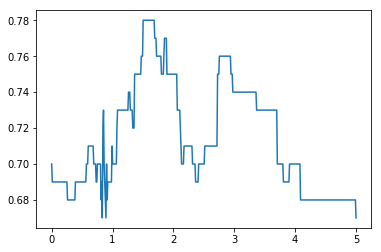

In [31]:
res1 = perform_IRL_4Attrs(optimalAction1, transition_probability,Rmax1 , lamda_list)
accuracy1 = res1['accuracy']
plt.plot(lamda_list, accuracy1)
plt.show()

### Q12 find lamda max###

In [32]:
# best accuracy with the 4 attributes IRL, Rmax is included in X and counted as an attribute
max_accuracy1 = max(accuracy1)
maxLamda1 = lamda_list[accuracy1.index(max_accuracy1)]
print(maxLamda1, max_accuracy1)

1.503006012024048 0.78


In [33]:
# # best accuracy with the 3 attributes IRL, the only difference is that here we take the Rmax out from X and put it in the bounding
# max_accuracy1_2 = max(accuracy1_2)
# maxLamda1_2 = lamda_list[accuracy1_2.index(max_accuracy1_2)]
# print(maxLamda1_2, max_accuracy1_2)

### Q13 generate heat maps of the ground truth and extracted reward###

In [34]:
res = perform_IRL_4Attrs(optimalAction1, transition_probability, Rmax1, [maxLamda1])
er = np.zeros([10,10])
for s in range(100):
    y = int(s // height)
    x = int(s % height)
    er[x,y] = res['reward'][s]
extracted_reward_max_lamda1 = er

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.3071e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.2532e-01 -0.0000e+00  5e+01  3e+00  8e-01  7e-01
 3: -1.5518e-01 -0.0000e+00  1e+01  8e-01  2e-01  2e-01
 4: -4.0093e-03 -0.0000e+00  7e-01  6e-02  2e-02  6e-03
 5: -3.8872e-05 -0.0000e+00  7e-03  6e-04  2e-04  6e-05
 6: -3.8865e-07 -0.0000e+00  7e-05  6e-06  2e-06  6e-07
 7: -3.8865e-09 -0.0000e+00  7e-07  6e-08  2e-08  6e-09
 8: -3.8865e-11 -0.0000e+00  7e-09  6e-10  2e-10  6e-11
Optimal solution found.
0.78


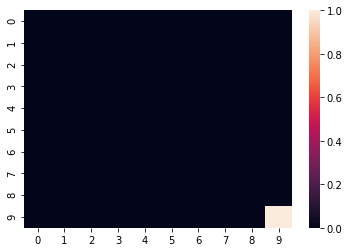

In [35]:
hm_rfunc1 = sns.heatmap(Rfunc1)

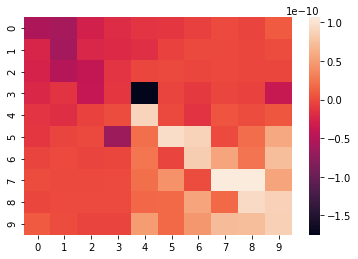

In [36]:
# print(extracted_reward_max_lamda1.reshape((height, width)))
hm_er1 = sns.heatmap(extracted_reward_max_lamda1)

### Q14 compute the optimal values of the states with extracted reward and generate heatmap ###

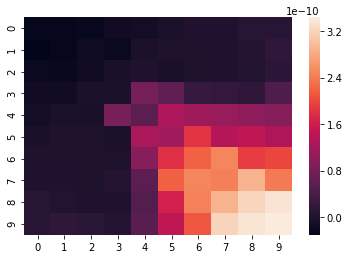

In [37]:
Vs_max_lamda1 = np.zeros(height * width)
# calVs(Vs_max_lamda1, tp, extracted_reward_max_lamda1, discount, theta)
Vs_max_lamda1 = calVs_new(Vs_max_lamda1, tp, extracted_reward_max_lamda1, discount, theta)
Vs_max_lamda1_2d = Vs_max_lamda1.reshape((height, width))
hm_vs = sns.heatmap(Vs_max_lamda1_2d)

### Q16 Use the extracted reward function found in question 13 to compute the optimal policy of the agent. ###

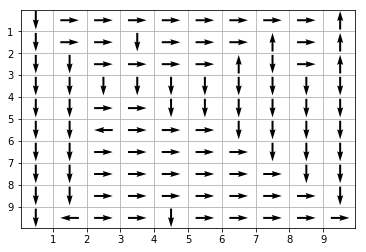

In [38]:
optimalAction_max_lamda1 = np.zeros(height * width)
calOptimalAction(optimalAction_max_lamda1, tp,extracted_reward_max_lamda1 , Vs_max_lamda1, discount)
optimalAction_max_lamda1_2d = optimalAction_max_lamda1.reshape((height, width))
arrows_max_lamda1 = action2Arrow(optimalAction_max_lamda1, arrows)
path_max_lamda1 = np.array(arrows_max_lamda1).reshape((height,width)).T
# print(tabulate(optimalAction_max_lamda1_2d.T,  tablefmt='fancy_grid'))
print_path(path_max_lamda1)

In [39]:
# Q18
# print(optimalAction2)
res = perform_IRL_4Attrs(optimalAction2, transition_probability, Rmax2, lamda_list)
accuracy2 = res['accuracy']


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5466e+00 -0.0000e+00  7e+02  1e+01  9e+00  3e+00
 2: -5.5235e+00 -0.0000e+00  2e+03  1e+01  8e+00  6e+00
 3: -2.0158e+01 -0.0000e+00  8e+03  1e+01  9e+00  2e+01
 4: -1.3025e+02 -0.0000e+00  5e+04  1e+01  9e+00  1e+02
 5: -1.2123e+04 -0.0000e+00  5e+06  1e+01  9e+00  1e+04
 6: -1.2122e+06 -0.0000e+00  5e+08  1e+01  9e+00  1e+06
 7: -1.2122e+08 -0.0000e+00  5e+10  1e+01  9e+00  1e+08
 8: -1.2122e+10 -0.0000e+00  5e+12  1e+01  9e+00  1e+10
Certificate of dual infeasibility found.
0.79
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5716e+00 -0.0000e+00  7e+02  1e+01  9e+00  3e+00
 2: -5.3086e+00 -0.0000e+00  2e+03  1e+01  8e+00  6e+00
 3: -1.8819e+01 -0.0000e+00  7e+03  1e+01  8e+00  2e+01
 4: -1.1115e+02 -0.0000e+00  4e+04  1e+01  8e+00  1e+02
 5: -1.0113e+04 -0.0000e+00  4e+06  1e+01  8e+00  1e+04
 6: -1

0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.8895e+00 -0.0000e+00  5e+02  1e+01  8e+00  3e+00
 2: -4.0674e+00 -0.0000e+00  7e+02  1e+01  6e+00  4e+00
 3: -1.1239e+01 -0.0000e+00  2e+03  9e+00  5e+00  1e+01
 4: -4.0184e+01 -0.0000e+00  9e+03  8e+00  5e+00  4e+01
 5: -2.3234e+03 -0.0000e+00  5e+05  8e+00  5e+00  2e+03
 6: -2.3221e+05 -0.0000e+00  5e+07  8e+00  5e+00  2e+05
 7: -2.3221e+07 -0.0000e+00  5e+09  8e+00  5e+00  2e+07
 8: -2.3221e+09 -0.0000e+00  5e+11  8e+00  5e+00  2e+09
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.9117e+00 -0.0000e+00  5e+02  1e+01  8e+00  3e+00
 2: -4.0216e+00 -0.0000e+00  7e+02  1e+01  6e+00  4e+00
 3: -1.0603e+01 -0.0000e+00  2e+03  8e+00  5e+00  1e+01
 4: -3.6329e+01 -0.0000e+00  8e+03  8e+00  5e+00  4e+01
 5: -1.9431e+03 -0.0000e+00  4e+05  8e+00  5e+00  2e+03
 

0.8
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -3.1436e+00 -0.0000e+00  4e+02  1e+01  7e+00  4e+00
 2: -3.5837e+00 -0.0000e+00  4e+02  8e+00  5e+00  4e+00
 3: -6.1792e+00 -0.0000e+00  8e+02  6e+00  4e+00  6e+00
 4: -1.7671e+01 -0.0000e+00  3e+03  6e+00  4e+00  2e+01
 5: -4.8114e+02 -0.0000e+00  7e+04  5e+00  3e+00  5e+02
 6: -4.7744e+04 -0.0000e+00  7e+06  5e+00  3e+00  5e+04
 7: -4.7744e+06 -0.0000e+00  7e+08  5e+00  3e+00  5e+06
 8: -4.7744e+08 -0.0000e+00  7e+10  5e+00  3e+00  5e+08
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -3.1565e+00 -0.0000e+00  4e+02  1e+01  7e+00  4e+00
 2: -3.5552e+00 -0.0000e+00  4e+02  8e+00  5e+00  4e+00
 3: -5.9914e+00 -0.0000e+00  8e+02  6e+00  4e+00  6e+00
 4: -1.7063e+01 -0.0000e+00  3e+03  6e+00  4e+00  2e+01
 5: -4.4843e+02 -0.0000e+00  6e+04  5e+00  3e+00  4e+02
 6

0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -3.1306e+00 -0.0000e+00  4e+02  1e+01  7e+00  3e+00
 2: -3.0690e+00 -0.0000e+00  3e+02  7e+00  4e+00  3e+00
 3: -3.8244e+00 -0.0000e+00  4e+02  5e+00  3e+00  4e+00
 4: -6.4171e+00 -0.0000e+00  8e+02  5e+00  3e+00  7e+00
 5: -2.3886e+01 -0.0000e+00  3e+03  4e+00  3e+00  2e+01
 6: -1.7456e+03 -0.0000e+00  2e+05  4e+00  2e+00  2e+03
 7: -1.7450e+05 -0.0000e+00  2e+07  4e+00  2e+00  2e+05
 8: -1.7449e+07 -0.0000e+00  2e+09  4e+00  2e+00  2e+07
 9: -1.7449e+09 -0.0000e+00  2e+11  4e+00  2e+00  2e+09
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -3.1170e+00 -0.0000e+00  4e+02  1e+01  7e+00  3e+00
 2: -3.0291e+00 -0.0000e+00  3e+02  7e+00  4e+00  3e+00
 3: -3.6828e+00 -0.0000e+00  4e+02  5e+00  3e+00  4e+00
 4: -5.9913e+00 -0.0000e+00  7e+02  5e+00  3e+00  6e+00
 

0.82
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9234e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.5972e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -2.3531e+00 -0.0000e+00  2e+02  4e+00  2e+00  2e+00
 4: -3.1142e+00 -0.0000e+00  4e+02  4e+00  2e+00  3e+00
 5: -7.1815e+00 -0.0000e+00  9e+02  3e+00  2e+00  7e+00
 6: -1.6736e+02 -0.0000e+00  2e+04  3e+00  1e+00  2e+02
 7: -1.6596e+04 -0.0000e+00  2e+06  3e+00  1e+00  2e+04
 8: -1.6596e+06 -0.0000e+00  2e+08  3e+00  1e+00  2e+06
 9: -1.6596e+08 -0.0000e+00  2e+10  3e+00  1e+00  2e+08
Certificate of dual infeasibility found.
0.82
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.9052e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.5639e+00 -0.0000e+00  2e+02  6e+00  3e+00  3e+00
 3: -2.2715e+00 -0.0000e+00  2e+02  4e+00  2e+00  2e+00
 4: -2.9751e+00 -0.0000e+00  3e+02  4e+00  2e+00  3e+00
 

0.8
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.6673e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.1834e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.5216e+00 -0.0000e+00  1e+02  3e+00  2e+00  2e+00
 4: -1.7404e+00 -0.0000e+00  2e+02  3e+00  1e+00  2e+00
 5: -3.1993e+00 -0.0000e+00  4e+02  2e+00  1e+00  3e+00
 6: -3.3237e+01 -0.0000e+00  4e+03  2e+00  1e+00  3e+01
 7: -3.0836e+03 -0.0000e+00  4e+05  2e+00  1e+00  3e+03
 8: -3.0834e+05 -0.0000e+00  4e+07  2e+00  1e+00  3e+05
 9: -3.0834e+07 -0.0000e+00  4e+09  2e+00  1e+00  3e+07
Certificate of dual infeasibility found.
0.81
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.6448e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.1527e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.4731e+00 -0.0000e+00  1e+02  3e+00  2e+00  2e+00
 4: -1.6449e+00 -0.0000e+00  2e+02  3e+00  1e+00  2e+00
 5

0.77
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.4041e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -1.8649e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.2156e+00 -0.0000e+00  1e+02  3e+00  2e+00  1e+00
 4: -9.3630e-01 -0.0000e+00  8e+01  2e+00  1e+00  1e+00
 5: -8.6627e-01 -0.0000e+00  2e+02  2e+00  9e-01  9e-01
 6: -1.2524e+00 -0.0000e+00  3e+02  2e+00  8e-01  1e+00
 7: -2.2184e+01 -0.0000e+00  4e+03  1e+00  6e-01  2e+01
 8: -2.2026e+03 -0.0000e+00  4e+05  1e+00  6e-01  2e+03
 9: -2.2025e+05 -0.0000e+00  4e+07  1e+00  6e-01  2e+05
10: -2.2025e+07 -0.0000e+00  4e+09  1e+00  6e-01  2e+07
Certificate of dual infeasibility found.
0.77
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.3830e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -1.8401e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.1961e+00 -0.0000e+00  1e+02  3e+00  2e+00  1e+00
 

 2: -1.6056e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.0061e+00 -0.0000e+00  8e+01  3e+00  2e+00  1e+00
 4: -5.2043e-01 -0.0000e+00  4e+01  1e+00  7e-01  6e-01
 5: -3.5387e-01 -0.0000e+00  5e+01  1e+00  7e-01  4e-01
 6: -3.9668e-01 -0.0000e+00  5e+01  8e-01  4e-01  4e-01
 7: -1.9209e+00 -0.0000e+00  3e+02  7e-01  3e-01  2e+00
 8: -1.4690e+02 -0.0000e+00  2e+04  6e-01  3e-01  1e+02
 9: -1.4685e+04 -0.0000e+00  2e+06  6e-01  3e-01  1e+04
10: -1.4685e+06 -0.0000e+00  2e+08  6e-01  3e-01  1e+06
11: -1.4685e+08 -0.0000e+00  2e+10  6e-01  3e-01  1e+08
Certificate of dual infeasibility found.
0.77
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.1615e+00 -0.0000e+00  3e+02  1e+01  5e+00  3e+00
 2: -1.5835e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -9.8808e-01 -0.0000e+00  8e+01  3e+00  2e+00  1e+00
 4: -4.9263e-01 -0.0000e+00  4e+01  1e+00  7e-01  5e-01
 5: -3.3759e-01 -0.0000e+00  5e+01  1e+00  6e-01  4e-01
 6: 

0.7
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.9785e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.3780e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -8.2047e-01 -0.0000e+00  7e+01  3e+00  1e+00  9e-01
 4: -3.4223e-01 -0.0000e+00  3e+01  1e+00  5e-01  4e-01
 5: -1.9852e-01 -0.0000e+00  2e+01  9e-01  4e-01  2e-01
 6: -7.9455e-02 -0.0000e+00  8e+00  3e-01  1e-01  9e-02
 7: -5.5249e-02 -0.0000e+00  9e+00  2e-01  1e-01  6e-02
 8: -1.0088e-01 -0.0000e+00  3e+01  2e-01  9e-02  1e-01
 9: -1.3405e+00 -0.0000e+00  3e+02  2e-01  7e-02  1e+00
10: -1.3239e+02 -0.0000e+00  3e+04  2e-01  7e-02  1e+02
11: -1.3239e+04 -0.0000e+00  3e+06  2e-01  7e-02  1e+04
12: -1.3239e+06 -0.0000e+00  3e+08  2e-01  7e-02  1e+06
13: -1.3239e+08 -0.0000e+00  3e+10  2e-01  7e-02  1e+08
Certificate of dual infeasibility found.
0.68
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.8135e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.2069e+00 -0.0000e+00  1e+02  5e+00  2e+00  1e+00
 3: -6.8106e-01 -0.0000e+00  6e+01  3e+00  1e+00  8e-01
 4: -2.4314e-01 -0.0000e+00  2e+01  1e+00  4e-01  3e-01
 5: -3.3244e-02 -0.0000e+00  5e+00  3e-01  1e-01  4e-02
 6: -2.3778e-03 -0.0000e+00  1e+00  9e-02  4e-02  5e-03
 7:  2.1853e-04 -0.0000e+00  1e-01  1e-02  5e-03  2e-04
 8:  3.5473e-06 -0.0000e+00  2e-03  2e-04  8e-05  2e-06
 9:  3.5459e-08 -0.0000e+00  2e-05  2e-06  8e-07  2e-08
10:  3.5459e-10 -0.0000e+00  2e-07  2e-08  8e-09  2e-10
11:  3.5459e-12 -0.0000e+00  2e-09  2e-10  8e-11  2e-12
Optimal solution found.
0.82
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.7968e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.1918e+00 -0.0000e+00  1e+02  5e+00  2e+00  1e+00
 3: -6.6900e-01 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6175e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.0397e+00 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -5.4981e-01 -0.0000e+00  5e+01  3e+00  1e+00  6e-01
 4: -1.5289e-01 -0.0000e+00  1e+01  8e-01  3e-01  2e-01
 5: -1.6825e-02 -0.0000e+00  3e+00  2e-01  1e-01  2e-02
 6: -4.9605e-04 -0.0000e+00  3e-01  3e-02  1e-02  1e-03
 7: -4.1236e-07 -0.0000e+00  5e-03  4e-04  2e-04  1e-05
 8: -4.1224e-09 -0.0000e+00  5e-05  4e-06  2e-06  1e-07
 9: -4.1224e-11 -0.0000e+00  5e-07  4e-08  2e-08  1e-09
10: -4.1224e-13 -0.0000e+00  5e-09  4e-10  2e-10  1e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6025e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.0271e+00 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -5.3998e-01 -0.0000e+00  5e+01  3e+00  1e+00  6e-01
 4: -1.4675e-01 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.4370e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -8.8953e-01 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -4.3463e-01 -0.0000e+00  5e+01  2e+00  9e-01  5e-01
 4: -8.6346e-02 -0.0000e+00  9e+00  6e-01  2e-01  1e-01
 5: -1.3581e-03 -0.0000e+00  1e+00  9e-02  3e-02  4e-03
 6:  1.3901e-06 -0.0000e+00  2e-02  2e-03  7e-04  6e-05
 7:  1.3880e-08 -0.0000e+00  2e-04  2e-05  7e-06  6e-07
 8:  1.3880e-10 -0.0000e+00  2e-06  2e-07  7e-08  6e-09
 9:  1.3880e-12 -0.0000e+00  2e-08  2e-09  7e-10  6e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.4244e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -8.7918e-01 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -4.2685e-01 -0.0000e+00  5e+01  2e+00  9e-01  5e-01
 4: -8.2304e-02 -0.0000e+00  9e+00  6e-01  2e-01  1e-01
 5: -8.0841e-04 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.2845e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -7.6697e-01 -0.0000e+00  1e+02  4e+00  2e+00  9e-01
 3: -3.4386e-01 -0.0000e+00  4e+01  2e+00  8e-01  4e-01
 4: -5.3195e-02 -0.0000e+00  6e+00  4e-01  2e-01  7e-02
 5: -2.8180e-03 -0.0000e+00  5e-01  4e-02  2e-02  4e-03
 6: -2.8969e-05 -0.0000e+00  6e-03  5e-04  2e-04  4e-05
 7: -2.8962e-07 -0.0000e+00  6e-05  5e-06  2e-06  4e-07
 8: -2.8962e-09 -0.0000e+00  6e-07  5e-08  2e-08  4e-09
 9: -2.8962e-11 -0.0000e+00  6e-09  5e-10  2e-10  4e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.2737e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -7.5855e-01 -0.0000e+00  1e+02  4e+00  2e+00  9e-01
 3: -3.3774e-01 -0.0000e+00  4e+01  2e+00  8e-01  4e-01
 4: -5.1392e-02 -0.0000e+00  6e+00  4e-01  2e-01  7e-02
 5: -2.5198e-03 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.1547e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -6.6725e-01 -0.0000e+00  9e+01  4e+00  1e+00  8e-01
 3: -2.7266e-01 -0.0000e+00  4e+01  2e+00  7e-01  3e-01
 4: -3.5841e-02 -0.0000e+00  5e+00  3e-01  1e-01  5e-02
 5: -5.7839e-04 -0.0000e+00  3e-01  2e-02  7e-03  1e-03
 6: -5.8773e-06 -0.0000e+00  3e-03  2e-04  7e-05  1e-05
 7: -5.8768e-08 -0.0000e+00  3e-05  2e-06  7e-07  1e-07
 8: -5.8768e-10 -0.0000e+00  3e-07  2e-08  7e-09  1e-09
 9: -5.8768e-12 -0.0000e+00  3e-09  2e-10  7e-11  1e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.1455e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -6.6039e-01 -0.0000e+00  9e+01  4e+00  1e+00  8e-01
 3: -2.6787e-01 -0.0000e+00  4e+01  2e+00  6e-01  3e-01
 4: -3.5183e-02 -0.0000e+00  5e+00  3e-01  1e-01  5e-02
 5: -5.3187e-04 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.0435e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.8589e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -2.1690e-01 -0.0000e+00  3e+01  2e+00  6e-01  3e-01
 4: -2.7961e-02 -0.0000e+00  4e+00  3e-01  9e-02  4e-02
 5: -1.8724e-04 -0.0000e+00  1e-01  1e-02  3e-03  5e-04
 6: -1.8744e-06 -0.0000e+00  1e-03  1e-04  3e-05  5e-06
 7: -1.8744e-08 -0.0000e+00  1e-05  1e-06  3e-07  5e-08
 8: -1.8744e-10 -0.0000e+00  1e-07  1e-08  3e-09  5e-10
 9: -1.8744e-12 -0.0000e+00  1e-09  1e-10  3e-11  5e-12
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.0356e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.8028e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -2.1315e-01 -0.0000e+00  3e+01  2e+00  5e-01  3e-01
 4: -2.7427e-02 -0.0000e+00  4e+00  3e-01  9e-02  4e-02
 5: -1.8736e-04 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -9.4079e-01 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.1447e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.7033e-01 -0.0000e+00  3e+01  2e+00  5e-01  2e-01
 4: -2.1396e-02 -0.0000e+00  3e+00  2e-01  7e-02  3e-02
 5: -1.7606e-04 -0.0000e+00  6e-02  5e-03  1e-03  3e-04
 6: -1.7595e-06 -0.0000e+00  6e-04  5e-05  1e-05  3e-06
 7: -1.7595e-08 -0.0000e+00  6e-06  5e-07  1e-07  3e-08
 8: -1.7595e-10 -0.0000e+00  6e-08  5e-09  1e-09  3e-10
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -9.3404e-01 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.0991e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.6745e-01 -0.0000e+00  3e+01  2e+00  5e-01  2e-01
 4: -2.0988e-02 -0.0000e+00  3e+00  2e-01  7e-02  3e-02
 5: -1.7474e-04 -0.0000e+00  6e-02  4e-03  1e-03  3e-04
 6: -1.7463e-06 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -8.5251e-01 -0.0000e+00  3e+02  9e+00  3e+00  1e+00
 2: -4.5610e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.3450e-01 -0.0000e+00  3e+01  1e+00  4e-01  2e-01
 4: -1.6014e-02 -0.0000e+00  3e+00  2e-01  5e-02  2e-02
 5: -1.4903e-04 -0.0000e+00  4e-02  2e-03  7e-04  2e-04
 6: -1.4895e-06 -0.0000e+00  4e-04  2e-05  7e-06  2e-06
 7: -1.4895e-08 -0.0000e+00  4e-06  2e-07  7e-08  2e-08
 8: -1.4895e-10 -0.0000e+00  4e-08  2e-09  7e-10  2e-10
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -8.4668e-01 -0.0000e+00  3e+02  9e+00  3e+00  1e+00
 2: -4.5235e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.3227e-01 -0.0000e+00  2e+01  1e+00  4e-01  2e-01
 4: -1.5636e-02 -0.0000e+00  3e+00  2e-01  5e-02  2e-02
 5: -1.4634e-04 -0.0000e+00  3e-02  2e-03  7e-04  2e-04
 6: -1.4627e-06 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.7606e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.0772e-01 -0.0000e+00  9e+01  4e+00  1e+00  5e-01
 3: -1.0667e-01 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -1.0610e-02 -0.0000e+00  2e+00  1e-01  4e-02  1e-02
 5: -1.0399e-04 -0.0000e+00  2e-02  2e-03  4e-04  2e-04
 6: -1.0396e-06 -0.0000e+00  2e-04  1e-05  4e-06  2e-06
 7: -1.0396e-08 -0.0000e+00  2e-06  1e-07  4e-08  2e-08
 8: -1.0396e-10 -0.0000e+00  2e-08  1e-09  4e-10  2e-10
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.7100e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -4.0458e-01 -0.0000e+00  9e+01  4e+00  1e+00  5e-01
 3: -1.0492e-01 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -1.0230e-02 -0.0000e+00  2e+00  1e-01  4e-02  1e-02
 5: -1.0043e-04 -0.0000e+00  2e-02  1e-03  4e-04  1e-04
 6: -1.0040e-06 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.0942e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.6687e-01 -0.0000e+00  9e+01  4e+00  9e-01  5e-01
 3: -8.4460e-02 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -5.8398e-03 -0.0000e+00  1e+00  8e-02  2e-02  9e-03
 5: -5.9043e-05 -0.0000e+00  1e-02  9e-04  2e-04  9e-05
 6: -5.9034e-07 -0.0000e+00  1e-04  9e-06  2e-06  9e-07
 7: -5.9034e-09 -0.0000e+00  1e-06  9e-08  2e-08  9e-09
 8: -5.9034e-11 -0.0000e+00  1e-08  9e-10  2e-10  9e-11
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -7.0499e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -3.6418e-01 -0.0000e+00  9e+01  4e+00  9e-01  5e-01
 3: -8.3028e-02 -0.0000e+00  2e+01  1e+00  3e-01  1e-01
 4: -5.6610e-03 -0.0000e+00  1e+00  8e-02  2e-02  8e-03
 5: -5.7361e-05 -0.0000e+00  1e-02  9e-04  2e-04  8e-05
 6: -5.7352e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -6.5094e-01 -0.0000e+00  3e+02  9e+00  2e+00  9e-01
 2: -3.3146e-01 -0.0000e+00  8e+01  4e+00  9e-01  4e-01
 3: -6.5480e-02 -0.0000e+00  2e+01  9e-01  2e-01  1e-01
 4: -3.6780e-03 -0.0000e+00  1e+00  6e-02  1e-02  6e-03
 5: -3.7240e-05 -0.0000e+00  1e-02  6e-04  1e-04  6e-05
 6: -3.7237e-07 -0.0000e+00  1e-04  6e-06  1e-06  6e-07
 7: -3.7237e-09 -0.0000e+00  1e-06  6e-08  1e-08  6e-09
 8: -3.7237e-11 -0.0000e+00  1e-08  6e-10  1e-10  6e-11
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  8e+00  1e+00
 1: -6.4704e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -3.2909e-01 -0.0000e+00  8e+01  4e+00  9e-01  4e-01
 3: -6.4170e-02 -0.0000e+00  2e+01  9e-01  2e-01  9e-02
 4: -3.5238e-03 -0.0000e+00  1e+00  6e-02  1e-02  5e-03
 5: -3.5650e-05 -0.0000e+00  1e-02  6e-04  1e-04  5e-05
 6: -3.5646e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.9932e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -2.9958e-01 -0.0000e+00  8e+01  3e+00  8e-01  4e-01
 3: -5.0308e-02 -0.0000e+00  2e+01  8e-01  2e-01  8e-02
 4: -1.9824e-03 -0.0000e+00  7e-01  4e-02  9e-03  3e-03
 5: -1.9905e-05 -0.0000e+00  7e-03  4e-04  9e-05  3e-05
 6: -1.9904e-07 -0.0000e+00  7e-05  4e-06  9e-07  3e-07
 7: -1.9904e-09 -0.0000e+00  7e-07  4e-08  9e-09  3e-09
 8: -1.9904e-11 -0.0000e+00  7e-09  4e-10  9e-11  3e-11
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.9587e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -2.9739e-01 -0.0000e+00  8e+01  3e+00  8e-01  4e-01
 3: -5.0020e-02 -0.0000e+00  2e+01  8e-01  2e-01  8e-02
 4: -1.9621e-03 -0.0000e+00  7e-01  4e-02  9e-03  3e-03
 5: -1.9697e-05 -0.0000e+00  7e-03  4e-04  9e-05  3e-05
 6: -1.9696e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.5351e-01 -0.0000e+00  3e+02  8e+00  2e+00  8e-01
 2: -2.7673e-01 -0.0000e+00  8e+01  3e+00  7e-01  4e-01
 3: -4.4848e-02 -0.0000e+00  2e+01  8e-01  2e-01  7e-02
 4: -1.5286e-03 -0.0000e+00  6e-01  3e-02  7e-03  3e-03
 5: -1.5304e-05 -0.0000e+00  6e-03  3e-04  7e-05  3e-05
 6: -1.5303e-07 -0.0000e+00  6e-05  3e-06  7e-07  3e-07
 7: -1.5303e-09 -0.0000e+00  6e-07  3e-08  7e-09  3e-09
 8: -1.5303e-11 -0.0000e+00  6e-09  3e-10  7e-11  3e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.5043e-01 -0.0000e+00  3e+02  8e+00  2e+00  8e-01
 2: -2.7530e-01 -0.0000e+00  8e+01  3e+00  7e-01  4e-01
 3: -4.4423e-02 -0.0000e+00  2e+01  8e-01  2e-01  7e-02
 4: -1.4952e-03 -0.0000e+00  6e-01  3e-02  7e-03  2e-03
 5: -1.4967e-05 -0.0000e+00  6e-03  3e-04  7e-05  2e-05
 6: -1.4966e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.1264e-01 -0.0000e+00  3e+02  8e+00  2e+00  8e-01
 2: -2.5666e-01 -0.0000e+00  8e+01  3e+00  7e-01  4e-01
 3: -3.8428e-02 -0.0000e+00  1e+01  7e-01  2e-01  6e-02
 4: -1.0934e-03 -0.0000e+00  4e-01  2e-02  5e-03  2e-03
 5: -1.0929e-05 -0.0000e+00  4e-03  2e-04  5e-05  2e-05
 6: -1.0928e-07 -0.0000e+00  4e-05  2e-06  5e-07  2e-07
 7: -1.0928e-09 -0.0000e+00  4e-07  2e-08  5e-09  2e-09
 8: -1.0928e-11 -0.0000e+00  4e-09  2e-10  5e-11  2e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.0989e-01 -0.0000e+00  3e+02  8e+00  2e+00  8e-01
 2: -2.5519e-01 -0.0000e+00  8e+01  3e+00  7e-01  4e-01
 3: -3.7912e-02 -0.0000e+00  1e+01  7e-01  1e-01  6e-02
 4: -1.0645e-03 -0.0000e+00  4e-01  2e-02  5e-03  2e-03
 5: -1.0639e-05 -0.0000e+00  4e-03  2e-04  5e-05  2e-05
 6: -1.0639e-07 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.7602e-01 -0.0000e+00  2e+02  8e+00  2e+00  7e-01
 2: -2.3491e-01 -0.0000e+00  8e+01  3e+00  6e-01  3e-01
 3: -2.9568e-02 -0.0000e+00  1e+01  6e-01  1e-01  5e-02
 4: -7.2234e-04 -0.0000e+00  3e-01  2e-02  3e-03  1e-03
 5: -7.2162e-06 -0.0000e+00  3e-03  2e-04  3e-05  1e-05
 6: -7.2160e-08 -0.0000e+00  3e-05  2e-06  3e-07  1e-07
 7: -7.2160e-10 -0.0000e+00  3e-07  2e-08  3e-09  1e-09
 8: -7.2160e-12 -0.0000e+00  3e-09  2e-10  3e-11  1e-11
Optimal solution found.
0.88
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.7355e-01 -0.0000e+00  2e+02  8e+00  2e+00  7e-01
 2: -2.3320e-01 -0.0000e+00  8e+01  3e+00  6e-01  3e-01
 3: -2.8713e-02 -0.0000e+00  1e+01  6e-01  1e-01  5e-02
 4: -6.9406e-04 -0.0000e+00  3e-01  2e-02  3e-03  1e-03
 5: -6.9339e-06 -0.0000e+00  3e-03  2e-04  3e-05  1e-05
 6: -6.9337e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.3986e-01 -0.0000e+00  3e+02  7e+00  1e+00  7e-01
 2: -2.1680e-01 -0.0000e+00  7e+01  3e+00  6e-01  3e-01
 3: -2.2403e-02 -0.0000e+00  1e+01  5e-01  1e-01  4e-02
 4: -4.8461e-04 -0.0000e+00  2e-01  1e-02  2e-03  9e-04
 5: -4.8424e-06 -0.0000e+00  2e-03  1e-04  2e-05  9e-06
 6: -4.8423e-08 -0.0000e+00  2e-05  1e-06  2e-07  9e-08
 7: -4.8423e-10 -0.0000e+00  2e-07  1e-08  2e-09  9e-10
 8: -4.8423e-12 -0.0000e+00  2e-09  1e-10  2e-11  9e-12
Optimal solution found.
0.87
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.3726e-01 -0.0000e+00  3e+02  7e+00  1e+00  7e-01
 2: -2.1591e-01 -0.0000e+00  7e+01  3e+00  6e-01  3e-01
 3: -2.2248e-02 -0.0000e+00  1e+01  5e-01  1e-01  4e-02
 4: -4.7821e-04 -0.0000e+00  2e-01  1e-02  2e-03  8e-04
 5: -4.7785e-06 -0.0000e+00  2e-03  1e-04  2e-05  8e-06
 6: -4.7784e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.0533e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -2.0489e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -2.0179e-02 -0.0000e+00  1e+01  5e-01  9e-02  4e-02
 4: -3.9848e-04 -0.0000e+00  2e-01  1e-02  2e-03  7e-04
 5: -3.9820e-06 -0.0000e+00  2e-03  1e-04  2e-05  7e-06
 6: -3.9820e-08 -0.0000e+00  2e-05  1e-06  2e-07  7e-08
 7: -3.9820e-10 -0.0000e+00  2e-07  1e-08  2e-09  7e-10
 8: -3.9820e-12 -0.0000e+00  2e-09  1e-10  2e-11  7e-12
Optimal solution found.
0.86
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.0301e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -2.0409e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -2.0017e-02 -0.0000e+00  1e+01  5e-01  9e-02  4e-02
 4: -3.9266e-04 -0.0000e+00  2e-01  1e-02  2e-03  7e-04
 5: -3.9238e-06 -0.0000e+00  2e-03  1e-04  2e-05  7e-06
 6: -3.9238e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -3.7440e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.9427e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.7912e-02 -0.0000e+00  1e+01  5e-01  8e-02  3e-02
 4: -3.2142e-04 -0.0000e+00  2e-01  8e-03  1e-03  6e-04
 5: -3.2121e-06 -0.0000e+00  2e-03  8e-05  1e-05  6e-06
 6: -3.2121e-08 -0.0000e+00  2e-05  8e-07  1e-07  6e-08
 7: -3.2121e-10 -0.0000e+00  2e-07  8e-09  1e-09  6e-10
 8: -3.2121e-12 -0.0000e+00  2e-09  8e-11  1e-11  6e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -3.7231e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.9356e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.7750e-02 -0.0000e+00  1e+01  5e-01  8e-02  3e-02
 4: -3.1629e-04 -0.0000e+00  2e-01  8e-03  1e-03  6e-04
 5: -3.1609e-06 -0.0000e+00  2e-03  8e-05  1e-05  6e-06
 6: -3.1609e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.4659e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.8483e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.6065e-02 -0.0000e+00  1e+01  4e-01  8e-02  3e-02
 4: -2.6535e-04 -0.0000e+00  2e-01  7e-03  1e-03  5e-04
 5: -2.6519e-06 -0.0000e+00  2e-03  7e-05  1e-05  5e-06
 6: -2.6519e-08 -0.0000e+00  2e-05  7e-07  1e-07  5e-08
 7: -2.6519e-10 -0.0000e+00  2e-07  7e-09  1e-09  5e-10
 8: -2.6519e-12 -0.0000e+00  2e-09  7e-11  1e-11  5e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.4471e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.8420e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.5982e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.6296e-04 -0.0000e+00  2e-01  7e-03  1e-03  5e-04
 5: -2.6281e-06 -0.0000e+00  2e-03  7e-05  1e-05  5e-06
 6: -2.6281e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.2150e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.7647e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.4974e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3656e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3643e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3643e-08 -0.0000e+00  1e-05  6e-07  1e-07  4e-08
 7: -2.3643e-10 -0.0000e+00  1e-07  6e-09  1e-09  4e-10
 8: -2.3643e-12 -0.0000e+00  1e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.1980e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -1.7592e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.4901e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3471e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3459e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3459e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.0242e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.7040e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4665e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3323e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3311e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3311e-08 -0.0000e+00  1e-05  6e-07  1e-07  4e-08
 7: -2.3311e-10 -0.0000e+00  1e-07  6e-09  1e-09  4e-10
 8: -2.3311e-12 -0.0000e+00  1e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -3.0122e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.7003e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4672e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3399e-04 -0.0000e+00  1e-01  6e-03  1e-03  4e-04
 5: -2.3387e-06 -0.0000e+00  1e-03  6e-05  1e-05  4e-06
 6: -2.3387e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.8631e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6552e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4735e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3963e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3951e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3951e-08 -0.0000e+00  2e-05  6e-07  1e-07  4e-08
 7: -2.3951e-10 -0.0000e+00  2e-07  6e-09  1e-09  4e-10
 8: -2.3951e-12 -0.0000e+00  2e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.8521e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6519e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4738e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3949e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3938e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3937e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.7159e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6125e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4757e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3669e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3658e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3658e-08 -0.0000e+00  2e-05  6e-07  1e-07  4e-08
 7: -2.3658e-10 -0.0000e+00  2e-07  6e-09  1e-09  4e-10
 8: -2.3658e-12 -0.0000e+00  2e-09  6e-11  1e-11  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.7058e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6097e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4757e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3641e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3630e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3629e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.5810e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5755e-01 -0.0000e+00  9e+01  3e+00  4e-01  3e-01
 3: -1.4742e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3213e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.3203e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.3202e-08 -0.0000e+00  2e-05  6e-07  9e-08  4e-08
 7: -2.3202e-10 -0.0000e+00  2e-07  6e-09  9e-10  4e-10
 8: -2.3202e-12 -0.0000e+00  2e-09  6e-11  9e-12  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.5718e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5731e-01 -0.0000e+00  9e+01  3e+00  4e-01  3e-01
 3: -1.4740e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.3176e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.3166e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.3165e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.4572e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5436e-01 -0.0000e+00  1e+02  3e+00  4e-01  3e-01
 3: -1.4697e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.2656e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.2646e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.2646e-08 -0.0000e+00  2e-05  6e-07  9e-08  4e-08
 7: -2.2646e-10 -0.0000e+00  2e-07  6e-09  9e-10  4e-10
 8: -2.2646e-12 -0.0000e+00  2e-09  6e-11  9e-12  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.4488e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5415e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4692e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.2614e-04 -0.0000e+00  2e-01  6e-03  9e-04  4e-04
 5: -2.2604e-06 -0.0000e+00  2e-03  6e-05  9e-06  4e-06
 6: -2.2604e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.3434e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5163e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4627e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.2038e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.2028e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.2028e-08 -0.0000e+00  2e-05  6e-07  8e-08  4e-08
 7: -2.2028e-10 -0.0000e+00  2e-07  6e-09  8e-10  4e-10
 8: -2.2028e-12 -0.0000e+00  2e-09  6e-11  8e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.3356e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.5145e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4621e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1992e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1983e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1983e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.2385e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4933e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4537e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1386e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1377e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1377e-08 -0.0000e+00  2e-05  6e-07  8e-08  4e-08
 7: -2.1377e-10 -0.0000e+00  2e-07  6e-09  8e-10  4e-10
 8: -2.1377e-12 -0.0000e+00  2e-09  6e-11  8e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.2313e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4918e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4530e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1338e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1329e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1329e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.1416e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4742e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4430e-02 -0.0000e+00  1e+01  4e-01  5e-02  3e-02
 4: -2.0718e-04 -0.0000e+00  2e-01  6e-03  7e-04  4e-04
 5: -2.0710e-06 -0.0000e+00  2e-03  6e-05  7e-06  4e-06
 6: -2.0710e-08 -0.0000e+00  2e-05  6e-07  7e-08  4e-08
 7: -2.0710e-10 -0.0000e+00  2e-07  6e-09  7e-10  4e-10
 8: -2.0710e-12 -0.0000e+00  2e-09  6e-11  7e-12  4e-12
Optimal solution found.
0.85
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.1350e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4730e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4422e-02 -0.0000e+00  1e+01  4e-01  5e-02  3e-02
 4: -2.0671e-04 -0.0000e+00  2e-01  6e-03  7e-04  4e-04
 5: -2.0662e-06 -0.0000e+00  2e-03  6e-05  7e-06  4e-06
 6: -2.0662e-08 -0.0000

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.0521e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4586e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4308e-02 -0.0000e+00  1e+01  4e-01  5e-02  3e-02
 4: -2.0050e-04 -0.0000e+00  2e-01  5e-03  7e-04  4e-04
 5: -2.0042e-06 -0.0000e+00  2e-03  5e-05  7e-06  4e-06
 6: -2.0042e-08 -0.0000e+00  2e-05  5e-07  7e-08  4e-08
 7: -2.0042e-10 -0.0000e+00  2e-07  5e-09  7e-10  4e-10
 8: -2.0042e-12 -0.0000e+00  2e-09  5e-11  7e-12  4e-12
Optimal solution found.
0.84
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.0459e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4576e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4299e-02 -0.0000e+00  1e+01  4e-01  5e-02  3e-02
 4: -2.0002e-04 -0.0000e+00  2e-01  5e-03  7e-04  4e-04
 5: -1.9995e-06 -0.0000e+00  2e-03  5e-05  7e-06  4e-06
 6: -1.9994e-08 -0.0000

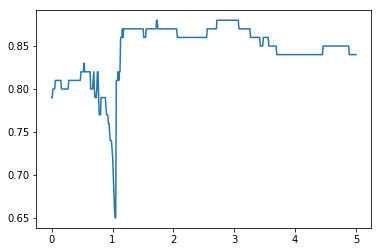

In [40]:
# Q18
plt.plot(lamda_list, accuracy2)
plt.show()

In [41]:
# Q19
max_accuracy2 = max(accuracy2)
maxLamda2 = lamda_list[accuracy2.index(max_accuracy2)]
print(maxLamda2, max_accuracy2)

1.723446893787575 0.88


In [42]:
# res2_2 = perform_IRL_3Attrs(optimalAction2, transition_probability,Rmax2 , lamda_list)
# accuracy2_2 = res2_2['accuracy']
# plt.plot(lamda_list, accuracy2_2)
# plt.show()

In [43]:
# max_accuracy2_2 = max(accuracy2_2)
# maxLamda2_2 = lamda_list[accuracy2_2.index(max_accuracy2_2)]
# print(maxLamda2_2, max_accuracy2_2)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.0760e+00 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -6.0921e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -2.3263e-01 -0.0000e+00  3e+01  2e+00  6e-01  3e-01
 4: -3.0209e-02 -0.0000e+00  4e+00  3e-01  1e-01  4e-02
 5: -2.5375e-04 -0.0000e+00  2e-01  1e-02  4e-03  6e-04
 6: -2.5450e-06 -0.0000e+00  2e-03  1e-04  4e-05  6e-06
 7: -2.5448e-08 -0.0000e+00  2e-05  1e-06  4e-07  6e-08
 8: -2.5448e-10 -0.0000e+00  2e-07  1e-08  4e-09  6e-10
 9: -2.5448e-12 -0.0000e+00  2e-09  1e-10  4e-11  6e-12
Optimal solution found.
0.88


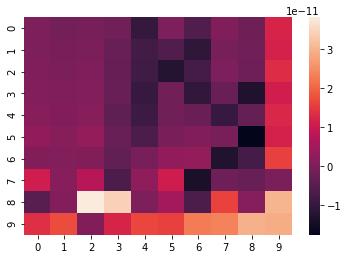

In [44]:
res = perform_IRL_4Attrs(optimalAction2, transition_probability, Rmax2, [maxLamda2])
er2 = np.zeros([10,10])
for s in range(100):
    y = int(s // height)
    x = int(s % height)
    er2[x,y] = res['reward'][s]
extracted_reward_max_lamda2 = er2
hm_er2 = sns.heatmap(extracted_reward_max_lamda2)

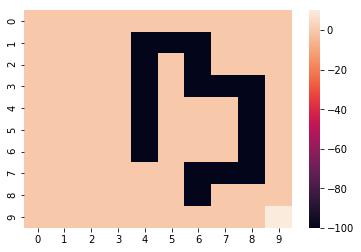

In [45]:
# Q20
hm_rfunc2 = sns.heatmap(Rfunc2)


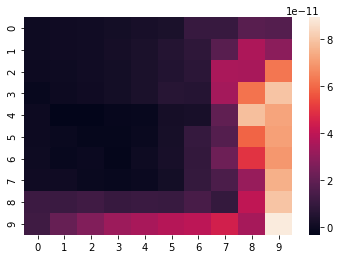

In [46]:
#Q21
Vs_max_lamda2 = np.zeros(height * width)
# calVs(Vs_max_lamda2, tp, extracted_reward_max_lamda2, discount, theta)
Vs_max_lamda2 = calVs_new(Vs_max_lamda2, tp, extracted_reward_max_lamda2, discount, theta)
Vs_max_lamda2_2d = Vs_max_lamda2.reshape((height, width))
hm_vs = sns.heatmap(Vs_max_lamda2_2d)

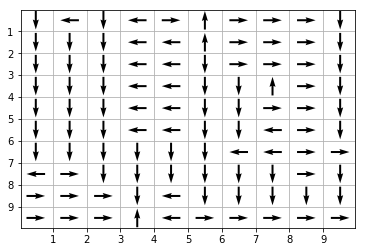

In [47]:
#Q23
optimalAction_max_lamda2 = np.zeros(height * width)
calOptimalAction(optimalAction_max_lamda2, tp,extracted_reward_max_lamda2 , Vs_max_lamda2, discount)
optimalAction_max_lamda2_2d = optimalAction_max_lamda2.reshape((height, width))
arrows_max_lamda2 = action2Arrow(optimalAction_max_lamda2, arrows)
path_max_lamda2 = np.array(arrows_max_lamda2).reshape((height,width)).T
# print(tabulate(optimalAction_max_lamda2_2d.T,  tablefmt='fancy_grid'))
print_path(path_max_lamda2)

#### Q25 - fix first discrepancy

In [48]:
def outOfEdge(state, action):
    if state==height*width-1: return False
    x = state // 10
    y = state % 10
    direction = [(0, -1), (1, 0), (0, 1), (-1, 0)]
    dx, dy = direction[action]
    x += dx
    y += dy
    if (x>=0 and x<=9 and y>=0 and y<=9):
        return False
    else:
        return True

In [49]:
def calOptimalAction_updated(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        if outOfEdge(s, optimal):
            mask = np.zeros_like(actionValue)
            mask[optimal] = 1
            actionValue = np.ma.masked_array(actionValue, mask=mask)
            optimal = np.argmax(actionValue)
        optimalAction[s] = optimal

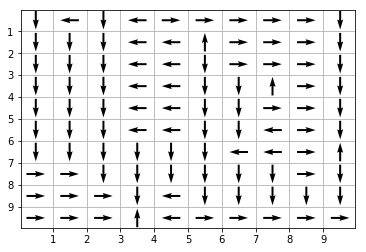

In [50]:
optimalAction_max_lamda2 = np.zeros(height * width)
calOptimalAction_updated(optimalAction_max_lamda2, tp,extracted_reward_max_lamda2 , Vs_max_lamda2, discount)
optimalAction_max_lamda2_2d = optimalAction_max_lamda2.reshape((height, width))
arrows_max_lamda2 = action2Arrow(optimalAction_max_lamda2, arrows)
path_max_lamda2 = np.array(arrows_max_lamda2).reshape((height,width)).T
# print(tabulate(optimalAction_max_lamda2_2d.T,  tablefmt='fancy_grid'))
print_path(path_max_lamda2)

In [51]:
# new accuracy
float(sum(np.equal(optimalAction2, optimalAction_max_lamda2))) / (height*width)

0.89